In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
from astropy.io import fits

In [10]:
def extract_spectrum(path, namefile):
    """
    Extracts spectrum data from a FITS file and cleans it by removing a specified wavelength range,
    addressing negative flux values, and ensuring it starts at 4280 Ångstrom.
    
    Arguments:
    path (str): The path to the directory containing the FITS file.
    namefile (str): The name of the FITS file.
    
    Returns:
    tuple: A tuple containing cleaned wavelengths and flux data.
    """
    with fits.open(path + namefile) as hdul:
        flux = hdul[1].data
        nx, wav0, i0, dwav = [hdul[1].header[k] for k in ("NAXIS1", "CRVAL1", "CRPIX1", "CD1_1")]
        wavelengths = wav0 + (np.arange(nx) - (i0 - 1)) * dwav
        wavelengths *= 10  # Convert to angstroms
    
    # Define the range to remove
    remove_range = (wavelengths >= 6120) & (wavelengths <= 6380)
    
    # Apply the filter
    clean_wavelengths = wavelengths[~remove_range]
    clean_flux = flux[~remove_range]
    
    # Address negative flux values
    negative_flux_indices = clean_flux < 0
    clean_flux[negative_flux_indices] = 0  # Set negative flux values to zero
    # Alternatively, you can choose to take the absolute value:
    # clean_flux[negative_flux_indices] = np.abs(clean_flux[negative_flux_indices])
    
    # Ensure the spectrum starts at 4280 Ångstrom
    start_index = np.searchsorted(clean_wavelengths, 4280)  # Find index closest to 4280
    clean_wavelengths = clean_wavelengths[start_index:]
    clean_flux = clean_flux[start_index:]
    clean_flux *= 100
    clean_flux /= 1e-16

    return clean_wavelengths, clean_flux

In [18]:
def plot_spectrum(wavelengths, flux, emission_lines, z=0.0, xlim=None, ylim=None, displace_lines=None, displace_lines_x = None, 
                  savefig=None, title=None):
    """
    Plots spectrum and annotates known emission lines.

    Arguments:
    wavelengths (array): Array of wavelengths.
    flux (array): Array of flux values.
    emission_lines (dict): Dictionary containing emission lines and their corresponding wavelengths.
    z (float): Redshift value (default is 0.0).
    xlim (tuple): Tuple containing the x-axis limits for the plot (optional).
    ylim (tuple): Tuple containing the y-axis limits for the plot (optional).
    displace_lines (dict): Dictionary containing emission line labels and their corresponding displacement factors (optional).
    displace_lines_x (dict): Dictionary containing emission line labels and their corresponding displacement factors for x-axis (optional).
    """
    # Calculate observed wavelengths with redshift
    observed_wavelengths = wavelengths * (1 + z)

    # Calculate max flux around emission lines for label positioning
    max_flux = []
    for wavelength in emission_lines.values():
        lambda_ob = wavelength * (z + 1)
        j = lambda_ob - 10
        k = lambda_ob + 10
        mask = (j < wavelengths) & (wavelengths < k)
        flux_values = flux[mask]
        try:
            max_flux.append(np.max(flux_values))
        except ValueError:
            max_flux.append(10)

    # Set the style for the plot
    #sns.set_style('white')

    # Plotting
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.set_xlabel('Observed Wavelength $(\AA)$', fontsize=20)
        ax.set_ylabel('Flux ($\mathrm{10^{-16} erg\ s^{-1} cm^{-2} \AA^{-1}}$)', fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.plot(wavelengths, flux, c="black")

        # Set title if provided
        if title:
            plt.title(title, fontsize=22)

        # Plot labels with adjusted positions
        for label, wavelength in emission_lines.items():
            wll_ob = wavelength * (z + 1)
            max_flux_val = max_flux[list(emission_lines.keys()).index(label)]
            bbox_props = dict(boxstyle="round", fc="w", ec="0.88", alpha=0.6, pad=0.1)

            # Check if label should be displaced
            if displace_lines and label in displace_lines:
                displacement_factor = displace_lines[label]
                # Adjust y-position based on displacement factor
                max_flux_val += displacement_factor
            else:
                displacement_factor = 2  # Default displacement factor

            # displacing label in the direction -x
            if displace_lines_x and label in displace_lines_x:
                displacement_factor_x = displace_lines_x[label]
                # Adjust y-position based on displacement factor
                wll_ob_dis = wll_ob + displacement_factor_x
            else:
                wll_ob_dis = wll_ob  # Default displacement factor
                
            ax.axvline(wll_ob, color='k', linewidth=0.8, alpha=0.5, linestyle='--')
            ax.annotate(label, (wll_ob_dis, max_flux_val), alpha=1, size=14,
                        xytext=(7.5, 5.6), textcoords='offset points', ha='right', va='bottom',
                        rotation=90, bbox=bbox_props, zorder=200)

        ###########
        #zoom plot 1#
        ###########
        axins = inset_axes(ax, width="32%", height="32%", loc=1, bbox_to_anchor=(-10, 100, 800, 500))
        axins.plot(wavelengths, flux, c = "black")
        axins.set_xlim(4340, 4420) # Limit the region for zoom
        axins.set_ylim(0.18, 0.6)
        axins.tick_params(axis='x', labelsize=12)
        axins.tick_params(axis='y', labelsize=12)

        for (label_, x), y in zip(emission_lines.items(), max_flux):
            wll_ob1 = x * (z + 1)
            axins.annotate(label_, (wll_ob1, y), alpha=1, size=14,
                        xytext=(7.5, 5.6), textcoords='offset points', ha='right', va='bottom', rotation=90, bbox=bbox_props, zorder=200)

        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", lw=1.2,  ec="0.6", zorder=1)

        ###########
        #zoom plot 2#
        ###########
        axins2 = inset_axes(ax, width="30%", height="32%", loc=1, bbox_to_anchor=(460, 100, 800, 500))
        axins2.plot(wavelengths, flux, c = "black", lw=1.2)
        axins2.set_xlim(7325, 7415) # Limit the region for zoom
        axins2.set_ylim(0.05, 0.25)
        axins2.tick_params(axis='x', labelsize=12)
        axins2.tick_params(axis='y', labelsize=12)

        for (label_, x), y in zip(emission_lines.items(), max_flux):
            wll_ob2 = x * (z + 1)
            axins2.annotate(label_, (wll_ob2, y), alpha=1, size=14,
                        xytext=(7.5, 5.6), textcoords='offset points', ha='right', va='bottom', rotation=90, bbox=bbox_props, zorder=200)

        mark_inset(ax, axins2, loc1=2, loc2=4, fc="none", lw=1.2,  ec="0.6", zorder=1)
        
    ax.xaxis.grid(False)  # Remove gridlines from the x-axis

    # Set limits if provided
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    plt.savefig(savefig)
    plt.show()  # Add this line if you want to display the plot.


<>:38: SyntaxWarning: invalid escape sequence '\A'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\A'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_102238/2269408463.py:38: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel('Observed Wavelength $(\AA)$', fontsize=20)
/tmp/ipykernel_102238/2269408463.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Flux ($\mathrm{10^{-16} erg\ s^{-1} cm^{-2} \AA^{-1}}$)', fontsize=20)


In [19]:
# Emission lines
emission_lines = {
        "Hγ": 4340.471, 
        "[O III] 4363": 4363.21,
        "Hβ": 4861.33,
        "[O III] 4959": 4958.911,
        "[O III] 5007": 5006.843,
        "He I 5876": 5875.66,     
        "Hα": 6562.82,
        "[N II] 6584": 6583.50,
        "He I 6678": 6678.16,
        "[S II] 6716": 6716.44,
        "[S II] 6731": 6730.82,
        "He I 7065": 7065.25,
        "[Ar III] 7136": 7135.80,
        "[O II] 7319": 7319.45,
        "[O II] 7330": 7330.20,
    }

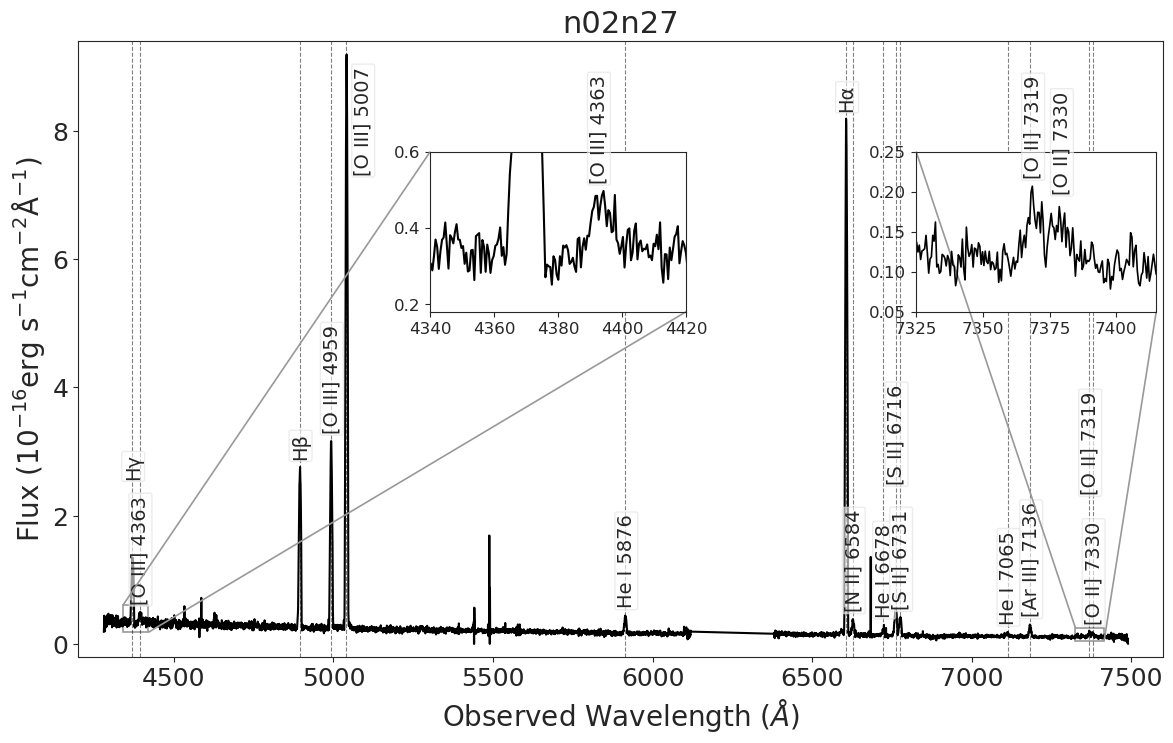

In [20]:
# Example usage
path = "../spectra_luis/"
namefile = "n02n27_1D_aberturaOIII_test.fits"
z = 0.0067
# Specify which lines should not have their labels adjusted
no_displace_lines = ["Hα"]
# Define lines to displace and their factor
# Define the lines and their respective displacement factors
displace_lines = {
    "Hγ": 1.1, 
    "[O III] 5007": -2., 
    "[S II] 6716": 1.8,
    "[O II] 7319": 2. # Apply a displacement factor of 1.5 to the Hα line  # Apply a displacement factor of 3.0 to the OIII line
}

# Define line to displacing in x-axis
displace_lines_x = {
    "[O III] 5007": 50, 
    }

wavelengths, flux = extract_spectrum(path, namefile)
savefig = "../spectra_luis/n02n27-spec-v2.png"
plot_spectrum(wavelengths, flux, emission_lines, z=z, xlim=(4200, 7600), ylim=(-0.2, 9.4), displace_lines=displace_lines, 
              displace_lines_x=displace_lines_x, savefig=savefig, title="n02n27")

# SPLUSn14s01.030140

In [15]:
# Emission lines
emission_lines1 = {
        "Hγ": 4340.471, 
        "[O III] 4363": 4363.21,
        "He I 4472": 4471.5,
        "Hβ": 4861.33,
        "[O III] 4959": 4958.911,
        "[O III] 5007": 5006.843,
        "He I 5876": 5875.66,    
        "[O I] 6300": 6300.3,
        "[S III] 6312": 6312.1,
        "[O I] 6364": 6363.77,
        "Hα": 6562.82,
        "[N II] 6584": 6583.50,
        "He I 6678": 6678.16,
        "[S II] 6716": 6716.44,
        "[S II] 6731": 6730.82,
        "He I 7065": 7065.25,
        "[Ar III] 7136": 7135.80,
        "[O II] 7319": 7319.45,
        "[O II] 7330": 7330.20,
    }

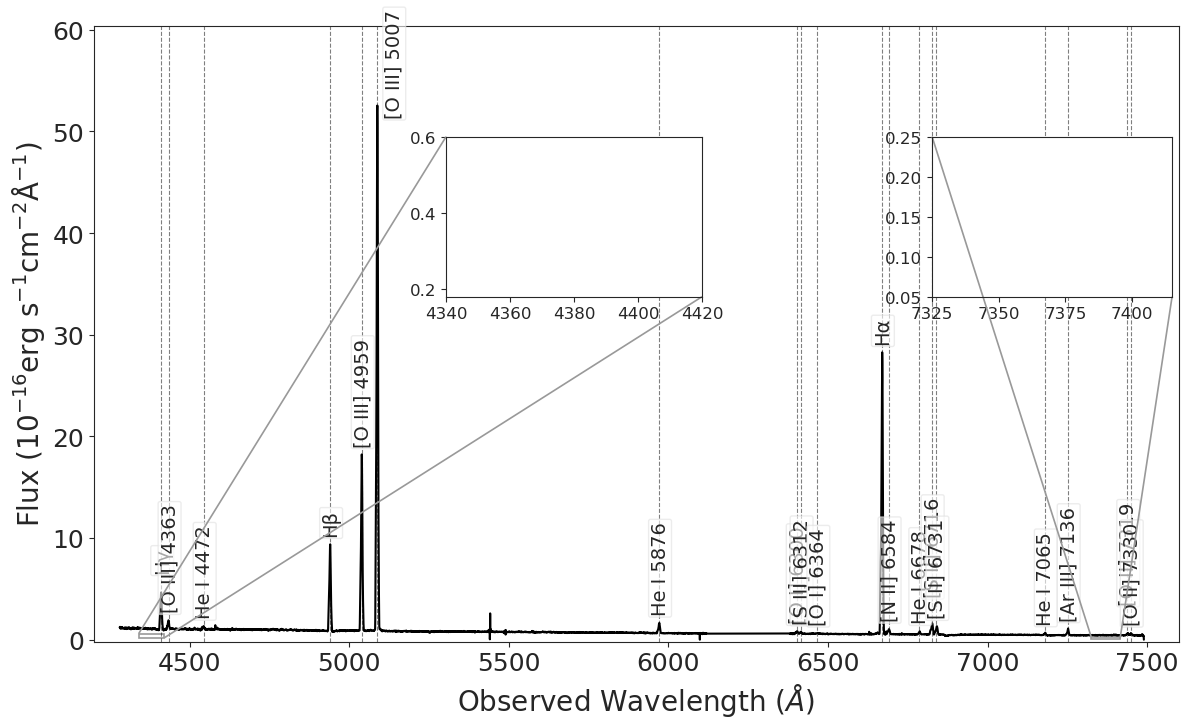

In [16]:
# Example usage
namefile1 = "n14s01_1D_aberturaOIII.fits"
z1 =  0.0162
# Specify which lines should not have their labels adjusted
no_displace_lines = ["Hα"]
# Define lines to displace and their factor
# Define the lines and their respective displacement factors
displace_lines1 = {
    "Hγ": 1.1, 
    "[O III] 5007": -2., 
    "[S II] 6716": 1.8,
    "[O II] 7319": 2. # Apply a displacement factor of 1.5 to the Hα line  # Apply a displacement factor of 3.0 to the OIII line
}

# Define line to displacing in x-axis
displace_lines_x1 = {
    "[O III] 5007": 50, 
    }

wavelengths1, flux1 = extract_spectrum(path, namefile1)
savefig1 = "../n14s01-spec.png"
plot_spectrum(wavelengths1, flux1, emission_lines1, z=z1, xlim=(4200, 7600), ylim=(-0.2, 60.4), displace_lines=displace_lines1, displace_lines_x=displace_lines_x1, savefig=savefig1)